# Bibliotecas e dependências

In [ ]:
# Baixando a biblioteca Pyvips
%%bash
apt install libvips-dev --no-install-recommends

In [ ]:
%pip install pyvips

In [ ]:
import numpy as np
import pandas as pd
import pyvips as pv #Realiza leitura da imagem
import time #Tempo de cada modelo
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline
from plotly import figure_factory as ff
from matplotlib.colors import ListedColormap

#Transformação em imagens
from skimage.segmentation import felzenszwalb, slic, join_segmentations, mark_boundaries
from skimage.measure import label
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology import disk

#Métricas
from tensorflow.keras.metrics import MeanIoU
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

#Modelos
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

#Acesso ao Drive
#Alterar para o Git quando subir o código open acess
from google.colab import drive
drive.mount('/content/drive')

## Pacote - BaseSuperpixel
Autor: Ian Nunes

In [4]:
from os import listdir
from os.path import isfile, join
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.segmentation import join_segmentations
from skimage import io
import numpy as np
import scipy as sp
from scipy.spatial import distance
import matplotlib.pyplot as plt
from datetime import datetime
from skimage.measure import label, regionprops
import math

import sys

def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data,axis=0)
    try:
        if not cov:
            cov = np.cov(data.T)
        inv_covmat = sp.linalg.inv(cov)
        left_term = np.dot(x_minus_mu, inv_covmat)
        mahal = np.dot(left_term, x_minus_mu.T)
        if type (mahal) is np.float64:
            return mahal
        return mahal.diagonal()
    except:
        return 9999999999999999999

def get_orderedsegments(label_img, max_pixels=25):
    uniques = np.unique(label_img, return_counts=True)
    filtered = [[],[]]
    filtered[0] = np.array(uniques[0][uniques[1]<=max_pixels])
    inds = filtered[0].argsort()
    sortedSegments = filtered[0][inds]
    return sortedSegments

def get_neighbors(label_img):
    #print(label_img.shape)
    props = regionprops(label_img)
    vizinhos_original = []
    vizinhos_original.append([])
    len_props=len(props)
    for i in range(0,len_props):
        #if (i)%int(len_props/5) == 0:
            #print(i)
        vizinhos_original.append([])
        for j in props[i].coords:
            if j[0]-1>=0:
                if props[i].label!=label_img[j[0]-1,j[1]]:
                    temp=label_img[j[0]-1,j[1]]
                    vizinhos_original[props[i].label].append(temp)
            if j[1]-1>=0:
                if props[i].label!=label_img[j[0],j[1]-1]:
                    vizinhos_original[props[i].label].append(label_img[j[0],j[1]-1])
            if j[0]+1<label_img.shape[0]:
                if props[i].label!=label_img[j[0]+1,j[1]]:
                    vizinhos_original[props[i].label].append(label_img[j[0]+1,j[1]])
            if j[1]+1<label_img.shape[1]:
                if props[i].label!=label_img[j[0],j[1]+1]:
                    vizinhos_original[props[i].label].append(label_img[j[0],j[1]+1])
        vizinhos_original[props[i].label] = list(np.unique(vizinhos_original[props[i].label]))
    #print(len_props)
    return vizinhos_original

def join_segments(label_img, img, min_number_pixels=50, distance='mean', verbose=True):
    if verbose:
        print('gerando labels unicos')
    label_img = label(label_img, connectivity=1)
    if verbose:
        print('gerando vizinhos unicos')
    vizinhos = get_neighbors(label_img)
    if verbose:
        print('gerando segmentos de tamanho minimo',min_number_pixels)
    t1=datetime.now()
    counter=0
    k=np.min(label_img)
    label_img_max=np.max(label_img)
    to_print = int(label_img_max/1000)
    if to_print<1000:
        to_print=1000
    while (k <= label_img_max):
        t2=datetime.now()
        i=k

        label_img_i_len = len(label_img[label_img==i])
        if (label_img_i_len>=min_number_pixels) or (label_img_i_len==0):
            k+=1
            continue

        minDistance = 9999999999999999999999
        minDistanceSeg = -1

        for v in vizinhos[i]:
            if v==i:
                continue
            if minDistanceSeg == -1:
                minDistanceSeg = v
            m=99999999999999999999999
            len_v = len(label_img[label_img==v])
            if len_v==0:
                continue
            if len_v>label_img_i_len and len_v>2:
                if distance=='mean':
                    m = mahalanobis(np.mean(img[label_img==i], axis=0),img[label_img==v])
                else:
                    m = mahalanobis(np.median(img[label_img==i], axis=0),img[label_img==v])

            elif label_img_i_len>2:
                if distance=='mean':
                    m = mahalanobis(np.mean(img[label_img==v], axis=0),img[label_img==i])
                else:
                    m = mahalanobis(np.median(img[label_img==v], axis=0),img[label_img==i])
            if m<minDistance:
                minDistance = m
                minDistanceSeg = v

        finalsegment = -1
        removedsegment = -1
        if minDistanceSeg<i:
            finalsegment = minDistanceSeg
            removedsegment = i
        else:
            finalsegment = i
            removedsegment = minDistanceSeg

        label_img[label_img==removedsegment] = finalsegment

        finalsegment_len = len(label_img[label_img==finalsegment])

        if finalsegment<=k and finalsegment_len<min_number_pixels:
            k=finalsegment
        else:
            k+=1

        vizinhos[finalsegment] = [*vizinhos[finalsegment],*vizinhos[removedsegment]]
        vizinhos[finalsegment] = list(np.unique(vizinhos[finalsegment]))
        temp = vizinhos[removedsegment].copy()
        for j in temp:
            try:
                vizinhos[j].remove(removedsegment)
            except:
                print('ERRO removendo:',removedsegment)
            vizinhos[j].append(finalsegment)

            vizinhos[j] = list(np.unique(vizinhos[j]))

        counter+=1
        if counter%to_print==0 or k > label_img_max:
            #print(label_img_max,'|',k,'-',i,'-',finalsegment, '-', removedsegment,"|", np.max(label_img), '|', datetime.now()-t1, datetime.now()-t2, "-", counter, '-', (datetime.now()-t1)/counter," | ",'final segment len: ',finalsegment_len)#, '|', len(vizinhos[finalsegment-1]))
            if verbose:
                print(label_img_max,'|',k,'|',distance,'|', datetime.now()-t1, datetime.now()-t2, "-", counter, '-', (datetime.now()-t1)/counter)
        if k > label_img_max:
            label_img = label(label_img, connectivity=1)
            unique_labels = np.unique(label_img, return_counts=True)
            smaller_than_min = len(unique_labels[1][unique_labels[1]<min_number_pixels])
            if smaller_than_min>0:
                if verbose:
                    print("reprocessing: ",smaller_than_min,'|',unique_labels[1][unique_labels[1]<min_number_pixels],"|",unique_labels[0][unique_labels[1]<min_number_pixels])
                k=np.min(label_img)
                label_img_max=np.max(label_img)
                vizinhos = get_neighbors(label_img)
            else:
                break

    label_img = label(label_img, connectivity=1)
    return label_img

def segment_slic(img, save_image_name_path, filename):
#     segments = slic(img, n_segments=int(img.shape[0]*img.shape[1]/1400), compactness=5, sigma=1, start_label=1)
#     np.savez(save_image_name_path.replace('.tif','_segments_slic01.npz'),segments)
#     segments = slic(img, n_segments=int(img.shape[0]*img.shape[1]/700), compactness=5, sigma=1, start_label=1)
#     np.savez(save_image_name_path.replace('.tif','_segments_slic02.npz'),segments)
#     segments = slic(img, n_segments=int(img.shape[0]*img.shape[1]/500), compactness=5, sigma=1, start_label=1)
#     np.savez(save_image_name_path.replace('.tif','_segments_slic03.npz'),segments)
#     segments = slic(img, n_segments=int(img.shape[0]*img.shape[1]/350), compactness=5, sigma=1, start_label=1)
#     np.savez(save_image_name_path.replace('.tif','_segments_slic04.npz'),segments)
#     segments = slic(img, n_segments=int(img.shape[0]*img.shape[1]/230), compactness=5, sigma=1, start_label=1)
#     np.savez(save_image_name_path.replace('.tif','_segments_slic05.npz'),segments)
    segments = slic(img, n_segments=int(img.shape[0]*img.shape[1]/170), compactness=5, sigma=1, start_label=1)
    np.savez(save_image_name_path.replace('.tif','_segments_slic06.npz'),segments)
    print('SLIC done', filename)

def segment_quick(img, save_image_name_path, filename):
#     segments = quickshift(img, kernel_size=2, max_dist=50, ratio=0.5)
#     np.savez(save_image_name_path.replace('.tif','_segments_quick01.npz'),segments)
    segments = quickshift(img, kernel_size=3, max_dist=50, ratio=0.5)
    np.savez(save_image_name_path.replace('.tif','_segments_quick02.npz'),segments)
#     segments = quickshift(img, kernel_size=4, max_dist=50, ratio=0.5)
#     np.savez(save_image_name_path.replace('.tif','_segments_quick03.npz'),segments)
#     segments = quickshift(img, kernel_size=5, max_dist=50, ratio=0.5)
#     np.savez(save_image_name_path.replace('.tif','_segments_quick04.npz'),segments)
    print('Quick done', filename)

def segment_felz(img, save_image_name_path, filename):
    segments = felzenszwalb(img, scale=50, sigma=0.5, min_size=50)
    np.savez(save_image_name_path.replace('.tif','_segments_fz01.npz'),segments)
    segments = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
    np.savez(save_image_name_path.replace('.tif','_segments_fz02.npz'),segments)
#     segments = felzenszwalb(img, scale=200, sigma=0.5, min_size=50)
#     np.savez(save_image_name_path.replace('.tif','_segments_fz03.npz'),segments)
    segments = felzenszwalb(img, scale=400, sigma=0.5, min_size=50)
    np.savez(save_image_name_path.replace('.tif','_segments_fz04.npz'),segments)
    segments = felzenszwalb(img, scale=50, sigma=0.5, min_size=100)
    np.savez(save_image_name_path.replace('.tif','_segments_fz05.npz'),segments)
    segments = felzenszwalb(img, scale=100, sigma=0.5, min_size=100)
    np.savez(save_image_name_path.replace('.tif','_segments_fz06.npz'),segments)
#     segments = felzenszwalb(img, scale=50, sigma=0.7, min_size=50)
#     np.savez(save_image_name_path.replace('.tif','_segments_fz07.npz'),segments)
#     segments = felzenszwalb(img, scale=100, sigma=0.7, min_size=50)
#     np.savez(save_image_name_path.replace('.tif','_segments_fz08.npz'),segments)
#     segments = felzenszwalb(img, scale=200, sigma=0.7, min_size=50)
#     np.savez(save_image_name_path.replace('.tif','_segments_fz09.npz'),segments)
#     segments = felzenszwalb(img, scale=400, sigma=0.7, min_size=50)
#     np.savez(save_image_name_path.replace('.tif','_segments_fz10.npz'),segments)
#     segments = felzenszwalb(img, scale=50, sigma=0.7, min_size=100)
#     np.savez(save_image_name_path.replace('.tif','_segments_fz11.npz'),segments)
#     segments = felzenszwalb(img, scale=100, sigma=0.7, min_size=100)
#     np.savez(save_image_name_path.replace('.tif','_segments_fz12.npz'),segments)
    print('Felzenszwalb done', filename)

def segment_felz_slic(original_img, chunk_size,distance,min_number_pixels, dataset, filename, save_image_name_path):
#     final_segments = np.zeros((original_img.shape[0],original_img.shape[1]),dtype=np.int32)
#     for k in range(0,math.ceil(final_segments.shape[0]/chunk_size)):
#         for l in range(0,math.ceil(final_segments.shape[1]/chunk_size)):
#             img = original_img[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size]
#             segments = join_segmentations(slic(img, n_segments=int(img.shape[0]*img.shape[1]/2000), compactness=5, sigma=1, start_label=1), felzenszwalb(img, scale=200, sigma=0.7, min_size=200))
#             segments = join_segments(segments, img, dataset, filename, min_number_pixels=min_number_pixels, distance=distance)
#             final_segments[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size] = segments+1+np.max(final_segments)
#     segments = label(final_segments, connectivity=1)
#     np.savez(save_image_name_path.replace('.tif','_segments_fz_slic01_'+distance+'_'+str(min_number_pixels)+'.npz'),segments)

    final_segments = np.zeros((original_img.shape[0],original_img.shape[1]),dtype=np.int32)
    for k in range(0,math.ceil(final_segments.shape[0]/chunk_size)):
        for l in range(0,math.ceil(final_segments.shape[1]/chunk_size)):
            img = original_img[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size]
            segments = join_segmentations(slic(img, n_segments=int(img.shape[0]*img.shape[1]/1500), compactness=5, sigma=1, start_label=1), felzenszwalb(img, scale=100, sigma=0.7, min_size=150))
            segments = join_segments(segments, img, dataset, filename, min_number_pixels=min_number_pixels, distance=distance)
            final_segments[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size] = segments+1+np.max(final_segments)
    segments = label(final_segments, connectivity=1)
    np.savez(save_image_name_path.replace('.tif','_segments_fz_slic02_'+distance+'_'+str(min_number_pixels)+'.npz'),segments)

#     final_segments = np.zeros((original_img.shape[0],original_img.shape[1]),dtype=np.int32)
#     for k in range(0,math.ceil(final_segments.shape[0]/chunk_size)):
#         for l in range(0,math.ceil(final_segments.shape[1]/chunk_size)):
#             img = original_img[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size]
#             segments = join_segmentations(slic(img, n_segments=int(img.shape[0]*img.shape[1]/1000), compactness=5, sigma=1, start_label=1), felzenszwalb(img, scale=100, sigma=0.7, min_size=150))
#             segments = join_segments(segments, img, dataset, filename, min_number_pixels=min_number_pixels, distance=distance)
#             final_segments[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size] = segments+1+np.max(final_segments)
#     segments = label(final_segments, connectivity=1)
#     np.savez(save_image_name_path.replace('.tif','_segments_fz_slic03_'+distance+'_'+str(min_number_pixels)+'.npz'),segments)

    final_segments = np.zeros((original_img.shape[0],original_img.shape[1]),dtype=np.int32)
    for k in range(0,math.ceil(final_segments.shape[0]/chunk_size)):
        for l in range(0,math.ceil(final_segments.shape[1]/chunk_size)):
            img = original_img[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size]
            segments = join_segmentations(slic(img, n_segments=int(img.shape[0]*img.shape[1]/500), compactness=5, sigma=1, start_label=1), felzenszwalb(img, scale=50, sigma=0.7, min_size=100))
            segments = join_segments(segments, img, dataset, filename, min_number_pixels=min_number_pixels, distance=distance)
            final_segments[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size] = segments+1+np.max(final_segments)
    segments = label(final_segments, connectivity=1)
    np.savez(save_image_name_path.replace('.tif','_segments_fz_slic04_'+distance+'_'+str(min_number_pixels)+'.npz'),segments)

    print('Felzenszwalb-SLIC done', filename)

def segment_quick_slic(original_img, chunk_size,distance,min_number_pixels, dataset, filename, save_image_name_path):
#     final_segments = np.zeros((original_img.shape[0],original_img.shape[1]),dtype=np.int32)
#     for k in range(0,math.ceil(final_segments.shape[0]/chunk_size)):
#         for l in range(0,math.ceil(final_segments.shape[1]/chunk_size)):
#             img = original_img[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size]
#             segments = join_segmentations(slic(img, n_segments=int(img.shape[0]*img.shape[1]/2000), compactness=5, sigma=1, start_label=1),quickshift(img, kernel_size=5, max_dist=50, ratio=0.5))
#             segments = join_segments(segments, img, dataset, filename, min_number_pixels=min_number_pixels, distance=distance)
#             final_segments[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size] = segments+1+np.max(final_segments)
#     segments = label(final_segments, connectivity=1)
#     np.savez(save_image_name_path.replace('.tif','_segments_quick_slic01_'+distance+'_'+str(min_number_pixels)+'.npz'),segments)

#     final_segments = np.zeros((original_img.shape[0],original_img.shape[1]),dtype=np.int32)
#     for k in range(0,math.ceil(final_segments.shape[0]/chunk_size)):
#         for l in range(0,math.ceil(final_segments.shape[1]/chunk_size)):
#             img = original_img[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size]
#             segments = join_segmentations(slic(img, n_segments=int(img.shape[0]*img.shape[1]/1500), compactness=5, sigma=1, start_label=1),quickshift(img, kernel_size=5, max_dist=50, ratio=0.5))
#             segments = join_segments(segments, img, dataset, filename, min_number_pixels=min_number_pixels, distance=distance)
#             final_segments[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size] = segments+1+np.max(final_segments)
#     segments = label(final_segments, connectivity=1)
#     np.savez(save_image_name_path.replace('.tif','_segments_quick_slic02_'+distance+'_'+str(min_number_pixels)+'.npz'),segments)

#     final_segments = np.zeros((original_img.shape[0],original_img.shape[1]),dtype=np.int32)
#     for k in range(0,math.ceil(final_segments.shape[0]/chunk_size)):
#         for l in range(0,math.ceil(final_segments.shape[1]/chunk_size)):
#             img = original_img[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size]
#             segments = join_segmentations(slic(img, n_segments=int(img.shape[0]*img.shape[1]/1000), compactness=5, sigma=1, start_label=1),quickshift(img, kernel_size=5, max_dist=50, ratio=0.5))
#             segments = join_segments(segments, img, dataset, filename, min_number_pixels=min_number_pixels, distance=distance)
#             final_segments[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size] = segments+1+np.max(final_segments)
#     segments = label(final_segments, connectivity=1)
#     np.savez(save_image_name_path.replace('.tif','_segments_quick_slic03_'+distance+'_'+str(min_number_pixels)+'.npz'),segments)

#     final_segments = np.zeros((original_img.shape[0],original_img.shape[1]),dtype=np.int32)
#     for k in range(0,math.ceil(final_segments.shape[0]/chunk_size)):
#         for l in range(0,math.ceil(final_segments.shape[1]/chunk_size)):
#             img = original_img[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size]
#             segments = join_segmentations(slic(img, n_segments=int(img.shape[0]*img.shape[1]/500), compactness=5, sigma=1, start_label=1),quickshift(img, kernel_size=5, max_dist=50, ratio=0.5))
#             segments = join_segments(segments, img, dataset, filename, min_number_pixels=min_number_pixels, distance=distance)
#             final_segments[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size] = segments+1+np.max(final_segments)
#     segments = label(final_segments, connectivity=1)
#     np.savez(save_image_name_path.replace('.tif','_segments_quick_slic04_'+distance+'_'+str(min_number_pixels)+'.npz'), segments)
    print('Quick-SLIC done', filename)


def segment_felz_quick(original_img, chunk_size,distance,min_number_pixels, dataset, filename, save_image_name_path):
#     final_segments = np.zeros((original_img.shape[0],original_img.shape[1]),dtype=np.int32)
#     for k in range(0,math.ceil(final_segments.shape[0]/chunk_size)):
#         for l in range(0,math.ceil(final_segments.shape[1]/chunk_size)):
#             img = original_img[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size]
#             segments = join_segmentations(felzenszwalb(img, scale=200, sigma=0.7, min_size=200), quickshift(img, kernel_size=2, max_dist=50, ratio=0.5))
#             segments = join_segments(segments, img, dataset, filename, min_number_pixels=min_number_pixels, distance=distance)
#             final_segments[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size] = segments+1+np.max(final_segments)
#     segments = label(final_segments, connectivity=1)
#     np.savez(save_image_name_path.replace('.tif','_segments_fz_quick01_'+distance+'_'+str(min_number_pixels)+'.npz'),segments)

    final_segments = np.zeros((original_img.shape[0],original_img.shape[1]),dtype=np.int32)
    for k in range(0,math.ceil(final_segments.shape[0]/chunk_size)):
        for l in range(0,math.ceil(final_segments.shape[1]/chunk_size)):
            img = original_img[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size]
            segments = join_segmentations(felzenszwalb(img, scale=200, sigma=0.7, min_size=200), quickshift(img, kernel_size=3, max_dist=50, ratio=0.5))
            segments = join_segments(segments, img, dataset, filename, min_number_pixels=min_number_pixels, distance=distance)
            final_segments[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size] = segments+1+np.max(final_segments)
    segments = label(final_segments, connectivity=1)
    np.savez(save_image_name_path.replace('.tif','_segments_fz_quick02_'+distance+'_'+str(min_number_pixels)+'.npz'),segments)

#     final_segments = np.zeros((original_img.shape[0],original_img.shape[1]),dtype=np.int32)
#     for k in range(0,math.ceil(final_segments.shape[0]/chunk_size)):
#         for l in range(0,math.ceil(final_segments.shape[1]/chunk_size)):
#             img = original_img[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size]
#             segments = join_segmentations(felzenszwalb(img, scale=200, sigma=0.7, min_size=200), quickshift(img, kernel_size=4, max_dist=50, ratio=0.5))
#             segments = join_segments(segments, img, dataset, filename, min_number_pixels=min_number_pixels, distance=distance)
#             final_segments[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size] = segments+1+np.max(final_segments)
#     segments = label(final_segments, connectivity=1)
#     np.savez(save_image_name_path.replace('.tif','_segments_fz_quick03_'+distance+'_'+str(min_number_pixels)+'.npz'),segments)

    final_segments = np.zeros((original_img.shape[0],original_img.shape[1]),dtype=np.int32)
    for k in range(0,math.ceil(final_segments.shape[0]/chunk_size)):
        for l in range(0,math.ceil(final_segments.shape[1]/chunk_size)):
            img = original_img[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size]
            segments = join_segmentations(felzenszwalb(img, scale=200, sigma=0.7, min_size=200), quickshift(img, kernel_size=5, max_dist=50, ratio=0.5))
            segments = join_segments(segments, img, dataset, filename, min_number_pixels=min_number_pixels, distance=distance)
            final_segments[k*chunk_size:(k+1)*chunk_size,l*chunk_size:(l+1)*chunk_size] = segments+1+np.max(final_segments)
    segments = label(final_segments, connectivity=1)
    np.savez(save_image_name_path.replace('.tif','_segments_fz_quick04_'+distance+'_'+str(min_number_pixels)+'.npz'),segments)
    print('Felzenszwalb-Quick done', filename)

# Carregando Imagem e Máscara

In [ ]:
# Importar imagem
img_original = pv.Image.new_from_file('//content//drive//My Drive//Dados//google_1m_GM_t.tif', access="random")
img = img_original.crop(41450,6168,1000,1000).numpy() #Recorte da imagem apenas para testes

# Importar máscara
mask_img_original = pv.Image.new_from_file("//content//drive//My Drive//Dados//mascaras//mascara_pavuna.tif", access="random")
mask_img = mask_img_original.crop(41450,6168,1000,1000).numpy() #Recorte igual a imagem orignal

#Criando um mapa de cores para máscara
# {0: 'Não favela', 1: 'Favela'}
# mapa_cores = {0:'empty',  1: 'red'}

mapa_cores = {
    0: (0, 0, 0, 0),        # vazio
    1: (1, 0, 0, 1)         # vermelho
}

# Criar uma lista de cores baseada no dicionário
lista_cores = [mapa_cores[x] for x in [0,1]]
cmap_ = ListedColormap(lista_cores)

## Criação da figura e dos subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))

## Adicionando as imagens aos subplots
axs[0].imshow(img)
axs[0].set_title('Imagem de Satélite Original')

axs[1].imshow(mask_img, cmap=cmap_)
axs[1].set_title('Máscara/ Label')

# Adicionando a segunda plotagem da mesma imagem no mesmo eixo axs[1] sobreposta por axs[0]
axs[2].imshow(img)
axs[2].set_title('Imagem de Satélite/Máscara')

axs[2] = axs[2].twinx()
axs[2].imshow(mask_img,cmap=cmap_, alpha=0.5)

plt.show()

# Incremento de Features na imagem

## Funções para criar features


In [6]:
#Função para indices RGB
def compute_indexes(bands):
    return_indexes = {}
    B1 = R = bands[:,:,2] #Vermelho
    B2 = G = bands[:,:,1] #Verde
    B3 = B = bands[:,:,0] #Azul

    return_indexes['SSI']=(2*G + R + B) #spatial shape index

    return return_indexes

#Função para calcular a média do superpixel
def mean_image(image,label):
  im_rp  = image.reshape((image.shape[0]*image.shape[1],image.shape[2]))
  sli_1d = np.reshape(label,-1)
  uni    = np.unique(sli_1d)
  uu     = np.zeros(im_rp.shape)

  for i in uni:
    loc = np.where(sli_1d==i)[0]
    mm  = np.mean(im_rp[loc,:],axis=0)
    uu[loc,:] = mm

  superpixel = np.reshape(uu,[image.shape[0],image.shape[1],image.shape[2]]).astype('uint8')

  return superpixel

#Função para calcular o desvio padrão do superpixel
def std_image(image,label):
  im_rp  = image.reshape((image.shape[0]*image.shape[1],image.shape[2]))
  sli_1d = np.reshape(label,-1)
  uni    = np.unique(sli_1d)
  uu     = np.zeros(im_rp.shape)

  for i in uni:
    loc = np.where(sli_1d==i)[0]
    mm  = np.std(im_rp[loc,:],axis=0)
    uu[loc,:] = mm

  superpixel = np.reshape(uu,[image.shape[0],image.shape[1],image.shape[2]]).astype('uint8')

  return superpixel

#Função para calcular a mediana do superpixel
def median_image(image,label):
  im_rp  = image.reshape((image.shape[0]*image.shape[1],image.shape[2]))
  sli_1d = np.reshape(label,-1)
  uni    = np.unique(sli_1d)
  uu     = np.zeros(im_rp.shape)

  for i in uni:
    loc = np.where(sli_1d==i)[0]
    mm  = np.median(im_rp[loc,:],axis=0)
    uu[loc,:] = mm

  superpixel = np.reshape(uu,[image.shape[0],image.shape[1],image.shape[2]]).astype('uint8')

  return superpixel

#Função para calcular o máximo do superpixel
def max_image(image,label):
  im_rp  = image.reshape((image.shape[0]*image.shape[1],image.shape[2]))
  sli_1d = np.reshape(label,-1)
  uni    = np.unique(sli_1d)
  uu     = np.zeros(im_rp.shape)

  for i in uni:
    loc = np.where(sli_1d==i)[0]
    mm  = np.max(im_rp[loc,:],axis=0)
    uu[loc,:] = mm

  superpixel = np.reshape(uu,[image.shape[0],image.shape[1],image.shape[2]]).astype('uint8')

  return superpixel


#Função para criar máscara de entropia da imagem
def entropy_image(mask_image, n_disk=10):
    rng = np.random.default_rng()
    noise_mask = mask_image

    noise = (noise_mask * rng.random(noise_mask.shape) - 0.5 * noise_mask).astype(np.uint8)

    noise = noise.astype(np.uint8)
    image = noise + 250

    entropy_img = entropy(image, disk(n_disk))

    return entropy_img

#Função para criar o Superpixel
def superpixel_image_AllBands(image, min_number_pixels = 250, distance = 'mean', verbose=False):

    s2 = felzenszwalb(image, scale=100, sigma=0.8, min_size=min_number_pixels)

    if verbose:
        print(f'Felzenszwalb number of segments: {len(np.unique(s2))}')
    s1 = slic(image, n_segments=int(min_number_pixels/3), compactness=6, sigma=2, start_label=0)

    if verbose:
        print(f'SLIC number of segments: {len(np.unique(s1))}')
    final_segments = join_segmentations(s1, s2)

    #if verbose:
    #    print(f'Final number of segments: {len(np.unique(final_segments))}')
    #final_segments = join_segments(final_segments, image, min_number_pixels=min_number_pixels, distance=distance, verbose=False)

    #if verbose:
    #    print(f'Final number of segments: {len(np.unique(final_segments))}')

    return s1,s2, final_segments

## Adicionando as Features

In [ ]:
superpixel_slic, superpixel_fz, superpixel_final = superpixel_image_AllBands(img,min_number_pixels=200,verbose=True)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, superpixel_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, superpixel_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, superpixel_final))
ax[1, 0].set_title('Final')
ax[1, 1].imshow(mask_img)
ax[1, 1].set_title('Máscara')


for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [9]:
#Calculando medidas estatísticas para a junção dos superpixel de Felzenszwalbs e SLIC separadamente
##Felzenszwalbs
superpixel_fz_mean = mean_image(img,superpixel_fz)
superpixel_fz_median = median_image(img,superpixel_fz)
superpixel_fz_std = std_image(img,superpixel_fz)
superpixel_fz_entropy = entropy_image(superpixel_fz_median[:,:,0])

##SLIC
superpixel_slic_mean = mean_image(img,superpixel_slic)
superpixel_slic_median = median_image(img,superpixel_slic)
superpixel_slic_std = std_image(img,superpixel_slic)
superpixel_slic_entropy = entropy_image(superpixel_slic_median[:,:,0])

#Calculando o SSI
ssi = compute_indexes(img)
ssi = ssi['SSI']

#Criando o vetor contendo todas as Features
##Felzenszwalbs
features = np.concatenate((img,superpixel_fz_mean), axis=2)
features = np.concatenate((features,superpixel_fz_median), axis=2)
features = np.concatenate((features,superpixel_fz_std), axis=2)
features = np.dstack((features,superpixel_fz_entropy))

##Slic
features = np.concatenate((features,superpixel_slic_mean), axis=2)
features = np.concatenate((features,superpixel_slic_median), axis=2)
features = np.concatenate((features,superpixel_slic_std), axis=2)
features = np.dstack((features,superpixel_slic_entropy))

##SSI
features = np.dstack((features,ssi))

In [10]:
#Convertendo a imagem para vetor
feature_vetor = features.reshape(features.shape[0]*features.shape[1],features.shape[2])

#Convertendo a máscara para vetor
mask_img_vetor = mask_img.reshape(mask_img.shape[0]*mask_img.shape[1],1)

In [11]:
# Dividir o dataset em conjuntos de treino e teste (60% treino, 40% teste)
X = feature_vetor
y = mask_img_vetor

X_treino, X_teste, y_treino, y_teste = train_test_split( X, y, test_size=0.4, shuffle=True, random_state=42)

# Modelos

In [12]:
modelos = []

## Random Forest

In [13]:
nome = 'RandomForest'
modelo = RandomForestClassifier(random_state=42)
grid = {
    'modelo__max_depth':[int(x) for x in np.linspace(start=1, stop=3, num=3)],
    'modelo__n_estimators': [int(x) for x in np.linspace(start=50, stop=200, num=4)],
    'modelo__criterion': ('gini', 'entropy'),
}

modelos.append({'nome': nome, 'modelo': modelo, 'grid': grid})

## LigthGBM

In [14]:
nome = 'LGBMClassifier'
modelo = lgb.LGBMClassifier(random_state=42)
grid = {
    'modelo__num_leaves': [int(x) for x in np.linspace(start=5, stop=50,num=4)],
    'modelo__reg_alpha': [0, 1e-1, 1],
    'modelo__reg_lambda': [0, 1e-1, 1],
}

modelos.append({'nome': nome, 'modelo': modelo, 'grid': grid})

## GradientBoost

In [15]:
nome = 'GradientBoost'
modelo = GradientBoostingClassifier(random_state=42)
grid = {
    'modelo__n_estimators': [int(x) for x in np.linspace(start=50, stop=200, num=4)],
    'modelo__learning_rate': [round(x,3) for x in np.linspace(start = 0.1, stop=1.5,num=4)],
}

modelos.append({'nome': nome, 'modelo': modelo, 'grid': grid})

## K-means


In [16]:
nome = 'Kmeans'
modelo = KMeans(random_state=42)
grid = {
    'modelo__n_clusters': [int(x) for x in np.linspace(start=1, stop=2, num=2)],
    'modelo__max_iter': [int(x) for x in np.linspace(start=50, stop=500, num=10)],
    'modelo__algorithm': ['lloyd', 'elkan'],
}

modelos.append({'nome': nome, 'modelo': modelo, 'grid': grid})

## Naive-Bayes

In [17]:
nome = 'GaussianNB'
modelo = GaussianNB()
grid = {
    'modelo__n_features_in_': [int(x) for x in np.linspace(start=1, stop=20, num=3)],
    'modelo__epsilon_': [int(x) for x in np.linspace(start=1, stop=50, num=5)],
}

modelos.append({'nome': nome, 'modelo': modelo, 'grid': grid})

## Logistic

In [18]:
nome = 'LogisticRegression'
modelo = LogisticRegression(random_state=42)
grid = {
    'modelo__penalty': ['l2', 'l1', 'elasticnet'],
    'modelo__solver': ['lbfgs', 'sag'],
}

modelos.append({'nome': nome, 'modelo': modelo, 'grid': grid})

## MLPClassifier

In [19]:
nome = 'MLPClassifier'
modelo = MLPClassifier(random_state=42)
grid = {
    'modelo__max_iter': [int(x) for x in np.linspace(start=50, stop=300,num=4)],
}

modelos.append({'nome': nome, 'modelo': modelo, 'grid': grid})

In [ ]:
modelos_nn = []

In [ ]:
img_treino, img_teste = img/255, mask_img/255

# Execução dos Modelos

## Treino

In [20]:
def train_test(mat, X, y):
    modelo = mat['modelo']
    nome = mat['nome']
    grid = mat['grid']

    print(f'Começando {nome}.')
    ini = time.time()


    pipe = Pipeline([
        ('modelo', modelo)
    ])

    gscv = GridSearchCV(
        pipe,
        param_grid = grid,
        scoring = 'f1',
        verbose = 5,
        n_jobs = -1,
    )

    rscv = gscv.fit(X,y.ravel())

    fim = time.time()

    print(f'Término {nome} | Score: {round(rscv.best_score_,3)} | Time: {rscv.refit_time_}')

    return {'name':nome, 'object': rscv}

In [ ]:
%%time
resultados = [train_test(mat, X_treino, y_treino) for mat in modelos]

info_modelo = []
info_values = []
info_time = []

for i, v in enumerate(resultados):

    info_modelo.append(resultados[i]['name'])
    info_values.append(round(resultados[i]['object'].best_score_,3))
    info_time.append(resultados[i]['object'].refit_time_)

dados = pd.DataFrame({'Model': info_modelo, 'Score': info_values, 'Time': info_time})
fig = ff.create_table(dados, height_constant=20)
fig.show()

## Validação

In [ ]:
info_modelo = []
info_time = []
modelo_final = []
resultado = pd.DataFrame(columns=['modelo','F1 Grid', 'Acurácia','F1 Score','Precisao', 'Recall'])
resultado_roc = pd.DataFrame(columns=['classificadores', 'fpr','tpr','auc'])

for i, v in enumerate(resultados):

    info_modelo.append(resultados[i]['name'])
    info_time.append(resultados[i]['object'].refit_time_)
    info_values = round(resultados[i]['object'].best_score_,3)

    model = resultados[i]['object'].best_estimator_
    model.fit(X_treino, y_treino.ravel())

    y_pred = model.predict(X_teste)
    #y_proba = model.predict_proba(X_teste)[:,1]

    acc = round(accuracy_score(y_teste, y_pred),3)
    f1 = round(f1_score(y_teste, y_pred),3)
    pc = round(precision_score(y_teste, y_pred),3)
    re = round(recall_score(y_teste, y_pred),3)

    resultado = resultado._append({'modelo':resultados[i]['name'],
                            'F1 Grid': info_values,
                            'Acurácia':acc,
                            'F1 Score':f1,
                            'Precisao':pc,
                            'Recall': re}, ignore_index=True)

    modelo_final.append({'nome': resultados[i]['name'], 'modelo': model})

    fpr, tpr, _ = roc_curve(y_teste,  y_pred)
    auc = roc_auc_score(y_teste, y_pred)

    resultado_roc = resultado_roc._append({'classificadores':resultados[i]['name'],
                                        'fpr':fpr,
                                        'tpr':tpr,
                                        'auc':auc}, ignore_index=True)


resultado_roc.set_index('classificadores', inplace=True)
fig = ff.create_table(resultado, height_constant=20)
fig.show()

## Curva ROC

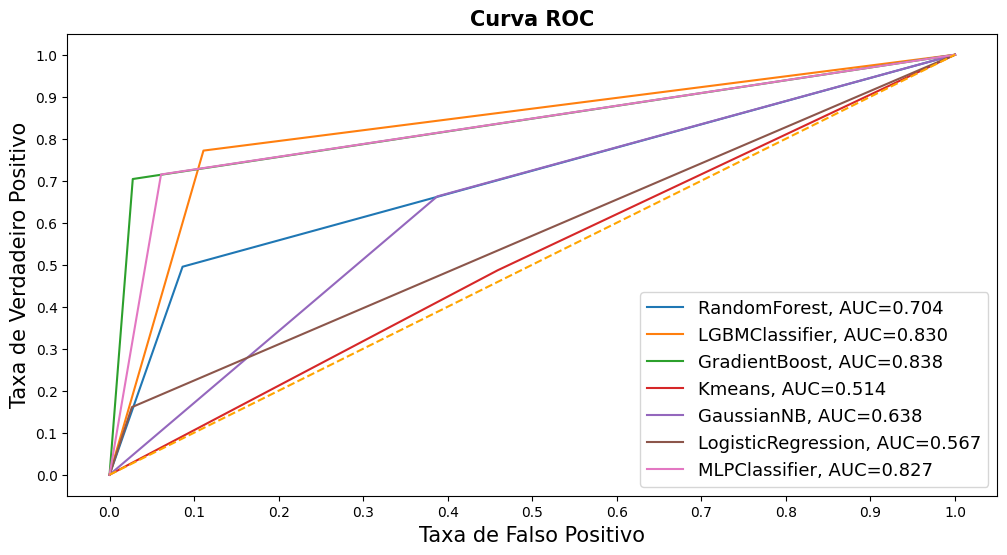

In [24]:
fig = plt.figure(figsize=(12,6))

for i in resultado_roc.index:
    plt.plot(resultado_roc.loc[i]['fpr'],
             resultado_roc.loc[i]['tpr'],
             label="{}, AUC={:.3f}".format(i, resultado_roc.loc[i]['auc']))

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Taxa de Falso Positivo", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("Taxa de Verdadeiro Positivo", fontsize=15)

plt.title('Curva ROC', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

#plt.savefig('roc_AGNS.png', format='png', dpi=100)
plt.show()

## Comparação Visual

In [25]:
pred_modelo = []

for i in range(len(modelo_final)):

    y_pred = modelo_final[i]['modelo'].predict(feature_vetor)

    pred_modelo.append({'nome': modelo_final[i]['nome'], 'pred': y_pred})

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(15, 15), sharex=True, sharey=True)

ax[0, 0].imshow(mask_img, cmap=cmap_)
ax[0, 0].set_title("Máscara")
ax[0, 1].imshow(np.reshape(pred_modelo[0]['pred'],(img.shape[0],img.shape[1])), cmap=cmap_)
ax[0, 1].set_title(pred_modelo[0]['nome'])
ax[1, 0].imshow(np.reshape(pred_modelo[1]['pred'],(img.shape[0],img.shape[1])), cmap=cmap_)
ax[1, 0].set_title(pred_modelo[1]['nome'])
ax[1, 1].imshow(np.reshape(pred_modelo[2]['pred'],(img.shape[0],img.shape[1])), cmap=cmap_)
ax[1, 1].set_title(pred_modelo[2]['nome'])
ax[2, 0].imshow(np.reshape(pred_modelo[3]['pred'],(img.shape[0],img.shape[1])), cmap=cmap_)
ax[2, 0].set_title(pred_modelo[3]['nome'])
ax[2, 1].imshow(np.reshape(pred_modelo[4]['pred'],(img.shape[0],img.shape[1])), cmap=cmap_)
ax[2, 1].set_title(pred_modelo[4]['nome'])
ax[3, 0].imshow(np.reshape(pred_modelo[5]['pred'],(img.shape[0],img.shape[1])), cmap=cmap_)
ax[3, 0].set_title(pred_modelo[5]['nome'])
ax[3, 1].imshow(np.reshape(pred_modelo[6]['pred'],(img.shape[0],img.shape[1])), cmap=cmap_)
ax[3, 1].set_title(pred_modelo[6]['nome'])


for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
iou = MeanIoU(num_classes=2)  # n_classes é o número de classes na sua segmentação

for i in range(len(pred_modelo)):
  iou.update_state(mask_img_vetor,pred_modelo[i]['pred'])
  mIoU = iou.result().numpy()
  print("IoU",f"{pred_modelo[i]['nome']} =", f"{mIoU*100:.2f}%")